----
# <b>ALTEGRAD 2023
# Lab 6: Deep Learning for Graphs (2/2)
# MARENGO Matteo | matteo.marengo@ens-paris-saclay.fr
# <b>PART 2 - How Powerful are Graph Neural Networks ?
----

## <b> TASK 6 / 7 </b>

In [5]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
models.py - 1/3
Matteo MARENGO - matteo.marengo@ens-paris-saclay.fr
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


class MessagePassing(nn.Module):
    def __init__(self, input_dim, output_dim, neighbor_aggr):
        super(MessagePassing, self).__init__()
        self.neighbor_aggr = neighbor_aggr
        self.fc1 = nn.Linear(input_dim, output_dim)
        self.fc2 = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):
        
        ############## Task 6
    
        ##################
        x_node = self.fc1(x)
        x_nbrs = self.fc2(x)
        m = torch.mm(adj, x_nbrs)

        if self.neighbor_aggr == 'sum':
            output = x_node + m
        elif self.neighbor_aggr == 'mean':
            deg = torch.spmm(adj, torch.ones(x.size(0),1, device=x.device))
            output = x_node + torch.div(m, deg)
        ##################
        
        if self.neighbor_aggr == 'sum':
            output = x_node + m
        elif self.neighbor_aggr == 'mean':
            deg = torch.spmm(adj, torch.ones(x.size(0),1, device=x.device))
            output = x_node + torch.div(m, deg)
            
        return output



class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, neighbor_aggr, readout, dropout):
        super(GNN, self).__init__()
        self.readout = readout
        self.mp1 = MessagePassing(input_dim, hidden_dim, neighbor_aggr)
        self.mp2 = MessagePassing(hidden_dim, hidden_dim, neighbor_aggr)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x, adj, idx):
        
        ############## Task 7
    
        ##################
        x = self.relu(self.mp1(x, adj))
        x = self.dropout(x)
        x = self.relu(self.mp2(x, adj))
        ##################
        
        if self.readout == 'sum':
            idx = idx.unsqueeze(1).repeat(1, x.size(1))
            out = torch.zeros(torch.max(idx)+1, x.size(1), device=x.device)
            out = out.scatter_add_(0, idx, x) 
        elif self.readout == 'mean':
            idx = idx.unsqueeze(1).repeat(1, x.size(1))
            out = torch.zeros(torch.max(idx)+1, x.size(1), device=x.device)
            out = out.scatter_add_(0, idx, x)
            count = torch.zeros(torch.max(idx)+1, x.size(1), device=x.device)
            count = count.scatter_add_(0, idx, torch.ones_like(x, device=x.device))
            out = torch.div(out, count)
            
        ############## Task 7
    
        ##################
        out = self.fc(out)
        ##################
        
        return out

In [6]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
utils.py - 2/3
"""

import numpy as np
import torch


def sparse_mx_to_torch_sparse_tensor(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse_coo_tensor(indices, values, shape)

## <b> TASK 4 / 5 / 8 / 9 / 10 / 11 </b>


neighbor_aggr = 'mean', readout = 'mean'
tensor([[ 0.0417,  0.2653, -0.0703,  0.2952],
        [ 0.0417,  0.2653, -0.0703,  0.2952],
        [ 0.0417,  0.2653, -0.0703,  0.2952],
        [ 0.0417,  0.2653, -0.0703,  0.2952],
        [ 0.0417,  0.2653, -0.0703,  0.2952],
        [ 0.0417,  0.2653, -0.0703,  0.2952],
        [ 0.0417,  0.2653, -0.0703,  0.2952],
        [ 0.0417,  0.2653, -0.0703,  0.2952],
        [ 0.0417,  0.2653, -0.0703,  0.2952],
        [ 0.0417,  0.2653, -0.0703,  0.2952]], grad_fn=<AddmmBackward0>)
neighbor_aggr = 'sum', readout = 'sum'
tensor([[-1.1166,  6.3057,  8.0510, -4.0615],
        [-1.2370,  6.9529,  8.8706, -4.4644],
        [-1.3574,  7.6001,  9.6902, -4.8673],
        [-1.4778,  8.2473, 10.5099, -5.2702],
        [-1.5981,  8.8944, 11.3295, -5.6730],
        [-1.7185,  9.5416, 12.1492, -6.0759],
        [-1.8389, 10.1888, 12.9688, -6.4788],
        [-1.9593, 10.8360, 13.7885, -6.8817],
        [-2.0796, 11.4832, 14.6081, -7.2846],
        [-2.2000, 1

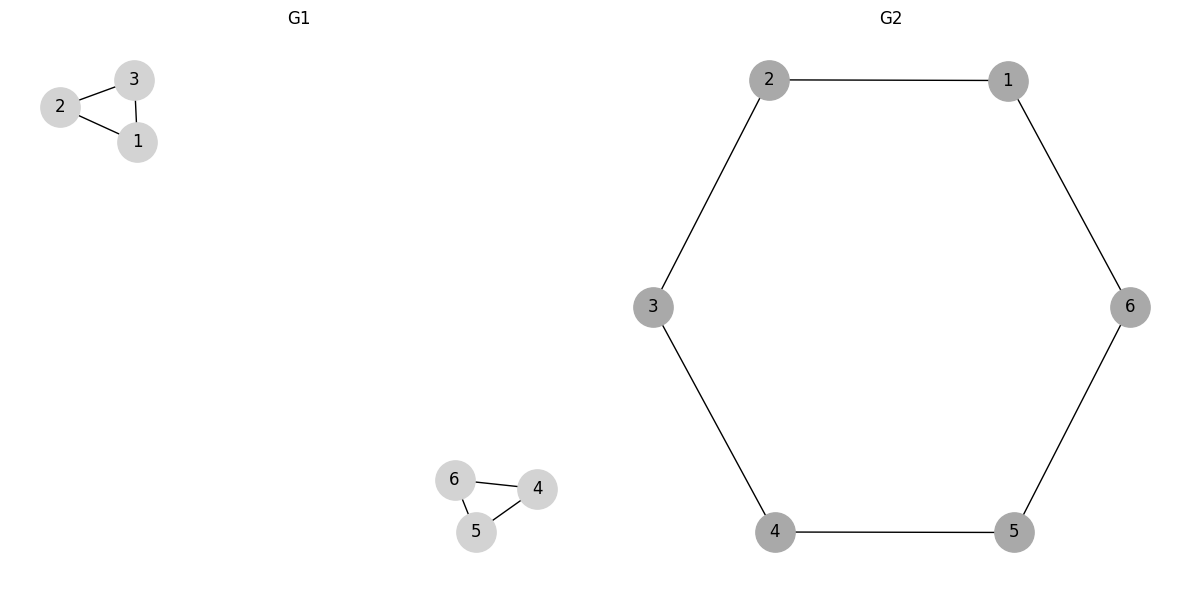

tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
neighbor_aggr = 'sum', readout = 'sum'
tensor([[-2.0476,  2.8498, -3.1056,  3.5313],
        [-2.0476,  2.8498, -3.1056,  3.5313]], grad_fn=<AddmmBackward0>)


In [7]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
expressive_power.py - 3/3
Matteo MARENGO - matteo.marengo@ens-paris-saclay.fr
"""

import networkx as nx
import numpy as np
import scipy.sparse as sp
import torch
import matplotlib.pyplot as plt

# from models import GNN
# from utils import sparse_mx_to_torch_sparse_tensor

# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
hidden_dim = 32
output_dim = 4
dropout = 0.0
neighbor_aggr = 'mean'
readout = 'mean'


############## Task 4
        
##################
# We create 10 cycle graphs of different lengths.
Gs = [nx.cycle_graph(i) for i in range(10, 20)]
##################

############## Task 5
        
##################
# create a sparse block diagonal matrix that contains the adjacency matrices of the graphs in Gs
adj = sp.block_diag([nx.adjacency_matrix(G) for G in Gs])
# create a tensor that contains the node features of all the graphs in Gs
x = np.ones((adj.shape[0], 1))
idx = []
for i, G in enumerate(Gs):
    idx += [i]*G.number_of_nodes()

adj = sparse_mx_to_torch_sparse_tensor(adj).to(device)
x = torch.FloatTensor(x).to(device)
idx = torch.LongTensor(idx).to(device)

# print(idx)
##################

############## Task 8
        
##################
# Initialize a GNN which uses the mean operator both for neighbor aggregation and for readout
# Hyperparameters are already set
gnn = GNN(1, hidden_dim, output_dim, neighbor_aggr, readout, dropout).to(device)
print("neighbor_aggr = 'mean', readout = 'mean'")
print(gnn(x, adj, idx))

# Initialize new GNNs which use different combinations of the sum and mean operators for neighbor aggregation and readout
gnn1 = GNN(1, hidden_dim, output_dim, 'sum', 'sum', dropout).to(device)
gnn2 = GNN(1, hidden_dim, output_dim, 'sum', 'mean', dropout).to(device)
gnn3 = GNN(1, hidden_dim, output_dim, 'mean', 'sum', dropout).to(device)
# Forward pass
out1 = gnn1(x, adj, idx)
out2 = gnn2(x, adj, idx)
out3 = gnn3(x, adj, idx)
print("neighbor_aggr = 'sum', readout = 'sum'")
print(out1)
print("neighbor_aggr = 'sum', readout = 'mean'")
print(out2)
print("neighbor_aggr = 'mean', readout = 'sum'")
print(out3)


##################


############## Task 9
        
##################
# Define the edges for G1 and G2
edges_g1 = [(1, 2), (2, 3), (3, 1),(4,5), (5,6), (6,4)]
edges_g2 = [(1, 2), (2, 3), (3, 4), (4, 5),(5,6), (6,1)]

# Create graph G1
G1 = nx.Graph()
G1.add_edges_from(edges_g1)

# Create graph G2
G2 = nx.Graph()
G2.add_edges_from(edges_g2)

# Plot G1 and G2
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot G1
nx.draw(G1, ax=axes[0], with_labels=True, node_color='lightgrey', node_size=800)
axes[0].set_title('G1')

# Plot G2
nx.draw(G2, ax=axes[1], with_labels=True, node_color='darkgrey', node_size=800)
axes[1].set_title('G2')

# Display the plots
plt.tight_layout()
plt.show()

##################

############## Task 10
        
##################
# For each batch of indices (both for training and evaluation)
# create a sparse block diagonal matrix that contains the adjacency matrices of the graphs G1 an G2
Gs = [G1, G2]
adj = sp.block_diag([nx.adjacency_matrix(G) for G in Gs])
# create a tensor that contains the node features of all the graphs in Gs
x = np.ones((adj.shape[0], 1))
idx = []
for i, G in enumerate(Gs):
    idx += [i]*G.number_of_nodes()

adj = sparse_mx_to_torch_sparse_tensor(adj).to(device)
x = torch.FloatTensor(x).to(device)
idx = torch.LongTensor(idx).to(device)

print(idx)
##################

############## Task 11
        
##################
# Initialize a GNN which uses the sum operator both for neighbor aggregation and for readout
# Hyperparameters are already set
gnn = GNN(1, hidden_dim, output_dim, 'sum', 'sum', dropout).to(device)
# Forward pass
out = gnn(x, adj, idx)
print("neighbor_aggr = 'sum', readout = 'sum'")
print(out)

##################

# <b>Graphs Test for question 4

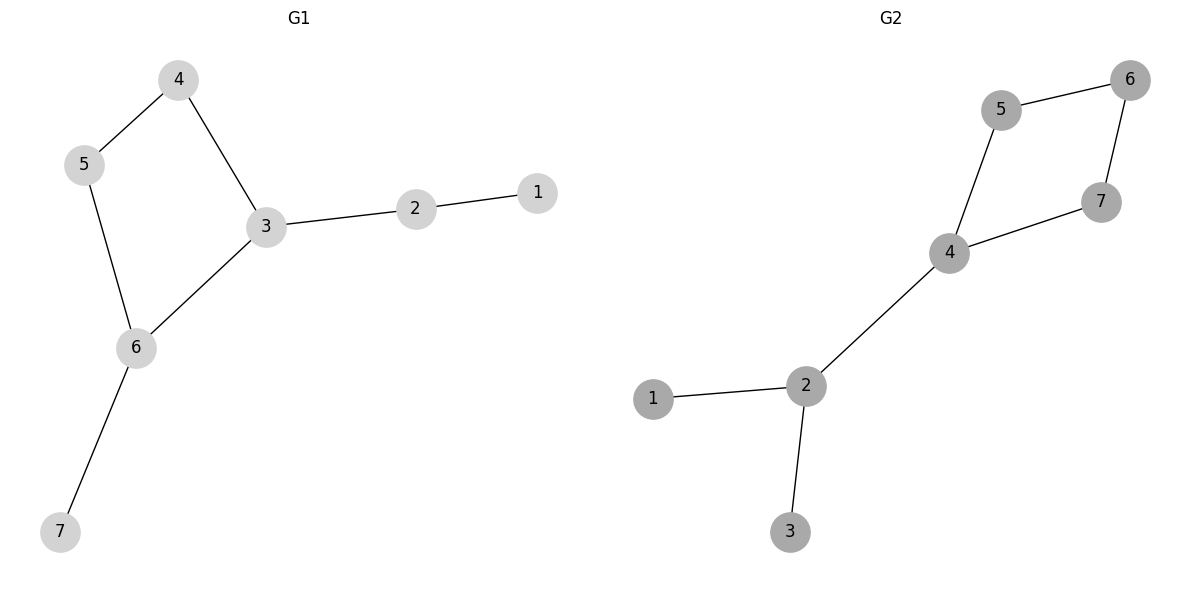

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])
neighbor_aggr = 'sum', readout = 'sum'
tensor([[-3.2920, -0.2205,  3.6589, -2.0161],
        [-3.3076, -0.2147,  3.6547, -1.9827]], grad_fn=<AddmmBackward0>)
[1, 2, 3, 2, 2, 3, 1]
[1, 3, 1, 3, 2, 2, 2]
2
3
2
2
3
2
G1 and G2 are not isomorphic


In [8]:
############## Task 9
        
##################
# Define the edges for G1 and G2
edges_g1 = [(1, 2), (2, 3), (3, 4),(4,5), (5,6),(6,3), (6,7)]
edges_g2 = [(1, 2), (2, 3), (2, 4), (4, 5),(5,6), (6,7), (7,4)]

# Create graph G1
G1 = nx.Graph()
G1.add_edges_from(edges_g1)

# Create graph G2
G2 = nx.Graph()
G2.add_edges_from(edges_g2)

# Plot G1 and G2
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot G1
nx.draw(G1, ax=axes[0], with_labels=True, node_color='lightgrey', node_size=800)
axes[0].set_title('G1')

# Plot G2
nx.draw(G2, ax=axes[1], with_labels=True, node_color='darkgrey', node_size=800)
axes[1].set_title('G2')

# Display the plots
plt.tight_layout()
plt.show()

##################

############## Task 10
        
##################
# For each batch of indices (both for training and evaluation)
# create a sparse block diagonal matrix that contains the adjacency matrices of the graphs G1 an G2
Gs = [G1, G2]
adj = sp.block_diag([nx.adjacency_matrix(G) for G in Gs])
# create a tensor that contains the node features of all the graphs in Gs
x = np.ones((adj.shape[0], 1))
idx = []
for i, G in enumerate(Gs):
    idx += [i]*G.number_of_nodes()

adj = sparse_mx_to_torch_sparse_tensor(adj).to(device)
x = torch.FloatTensor(x).to(device)
idx = torch.LongTensor(idx).to(device)

print(idx)
##################

############## Task 11
        
##################
# Initialize a GNN which uses the sum operator both for neighbor aggregation and for readout
# Hyperparameters are already set
gnn = GNN(1, hidden_dim, output_dim, 'sum', 'sum', dropout).to(device)
# Forward pass
out = gnn(x, adj, idx)
print("neighbor_aggr = 'sum', readout = 'sum'")
print(out)

degree_sequence1 = [G1.degree(node) for node in G1.nodes()]
degree_sequence2 = [G2.degree(node) for node in G2.nodes()]

print(degree_sequence1)
print(degree_sequence2)

nb1 = 0
nb2 = 0
nb3 = 0

for i in range(len(degree_sequence1)):
    if degree_sequence1[i] == 1:
        nb1 += 1
    if degree_sequence1[i] == 2:
        nb2 += 1
    if degree_sequence1[i] == 3:
        nb3 += 1

print(nb1)
print(nb2)
print(nb3)

nb1 = 0
nb2 = 0
nb3 = 0

for i in range(len(degree_sequence2)):
    if degree_sequence1[i] == 1:
        nb1 += 1
    if degree_sequence1[i] == 2:
        nb2 += 1
    if degree_sequence1[i] == 3:
        nb3 += 1

print(nb1)
print(nb2)
print(nb3)


# Test if G1 and G2 are isomorphic
are_isomorphic = nx.is_isomorphic(G1, G2)
print("G1 and G2 are isomorphic:" if are_isomorphic else "G1 and G2 are not isomorphic")

##################